<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/10_Kalman_Filter_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filter with KFAS — TSLA

이 노트북은 **Kalman Filter (Local Level: Random Walk + Noise)**를 이용해 TSLA 가격을 모델링하고,
다음 네 가지 백테스트/운영 방식을 예시로 보여줍니다.

1) **Full-sample (final fit)** — 전체 표본 적합 → 미래 *h* 스텝 예측 (평가용 X)
2) **Fixed-origin (holdout)** — 80% 학습으로 한 번 적합 → 테스트 전구간 예측(계수 고정)
3) **Rolling-origin + Rolling window** — 고정 창 길이 *W*, 매 스텝 재적합(1-step)
4) **Rolling-origin + Expanding window** — 누적 창, 매 스텝 재적합(1-step)

모형은 **KFAS** 패키지의 `SSModel/fitSSM/KFS/predict`를 사용한 **Local Level** 구조(관측오차 *H*, 상태오차 *Q*)입니다.


In [1]:
## ===========================
## 0) 패키지 설치/로딩 & 전역 옵션
## ===========================
need <- c("quantmod", "KFAS", "ggplot2", "tibble", "dplyr")
to_install <- setdiff(need, rownames(installed.packages()))
if (length(to_install) > 0) install.packages(to_install, repos = "https://cloud.r-project.org")
suppressPackageStartupMessages({
  library(quantmod)
  library(KFAS)
  library(ggplot2)
  library(tibble)
  library(dplyr)
})

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)  # 그림 크기/해상도
theme_set(theme_minimal(base_size = 13))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’




In [3]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

In [4]:
## ===========================
## 1) 데이터 로드 (TSLA 종가)
## ===========================
symbol <- "TSLA"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

suppressWarnings(suppressMessages(
  getSymbols(Symbols = symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
))

# Adjusted 열이 있으면 그것을, 없으면 Close를 사용
get_price_col <- function(x) {
  cn <- colnames(x)
  adj_idx <- grep("\\.Adjusted$", cn)
  if (length(adj_idx) == 1) xts::xts(x[, adj_idx], order.by = index(x)) else {
    close_idx <- grep("\\.Close$", cn)
    xts::xts(x[, close_idx], order.by = index(x))
  }
}

px_xts <- get_price_col(get(symbol))
colnames(px_xts) <- "Close"
px <- na.omit(px_xts)
df <- tibble(Date = as.Date(index(px)), Close = as.numeric(px$Close))
print(head(df))
cat(sprintf("%s: %d obs | %s ~ %s\n", symbol, nrow(df), as.character(df$Date[1]), as.character(df$Date[nrow(df)])))

[1] "TSLA"

# A tibble: 6 × 2
  Date       Close
  <date>     <dbl>
1 2022-01-03  400.
2 2022-01-04  383.
3 2022-01-05  363.
4 2022-01-06  355.
5 2022-01-07  342.
6 2022-01-10  353.
TSLA: 501 obs | 2022-01-03 ~ 2023-12-29


In [5]:
## ===========================
## 2) 학습/테스트 분할
## ===========================
train_ratio <- 0.8
n <- nrow(df)
split <- floor(n * train_ratio)

train <- df[1:split, ]
test  <- df[(split+1):n, ]
y_train <- train$Close
y_test  <- test$Close

cat(sprintf("train=%d, test=%d\n", length(y_train), length(y_test)))


train=400, test=101


In [6]:
## ===========================
## 3) 유틸함수 (지표/모형적합/예측)
## ===========================
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(y, yhat) {
  ss_res <- sum((y - yhat)^2, na.rm = TRUE)
  ss_tot <- sum((y - mean(y, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res/ss_tot
}

# Local Level (Random Walk + Noise) 모델 적합
fit_kfas_local_level <- function(y_vec) {
  y_ts <- ts(as.numeric(y_vec))
  mod <- SSModel(y_ts ~ SSMtrend(degree = 1, Q = list(NA)), H = NA)
  init_val <- rep(log(var(y_ts, na.rm = TRUE) + 1e-6), 2)  # (log H, log Q)
  fit <- tryCatch(fitSSM(mod, inits = init_val, method = "BFGS"), error = function(e) NULL)
  fit
}

predict_kfas <- function(fit, h = 1) {
  if (is.null(fit)) return(rep(NA_real_, h))
  as.numeric(predict(fit$model, n.ahead = h, interval = "none"))
}


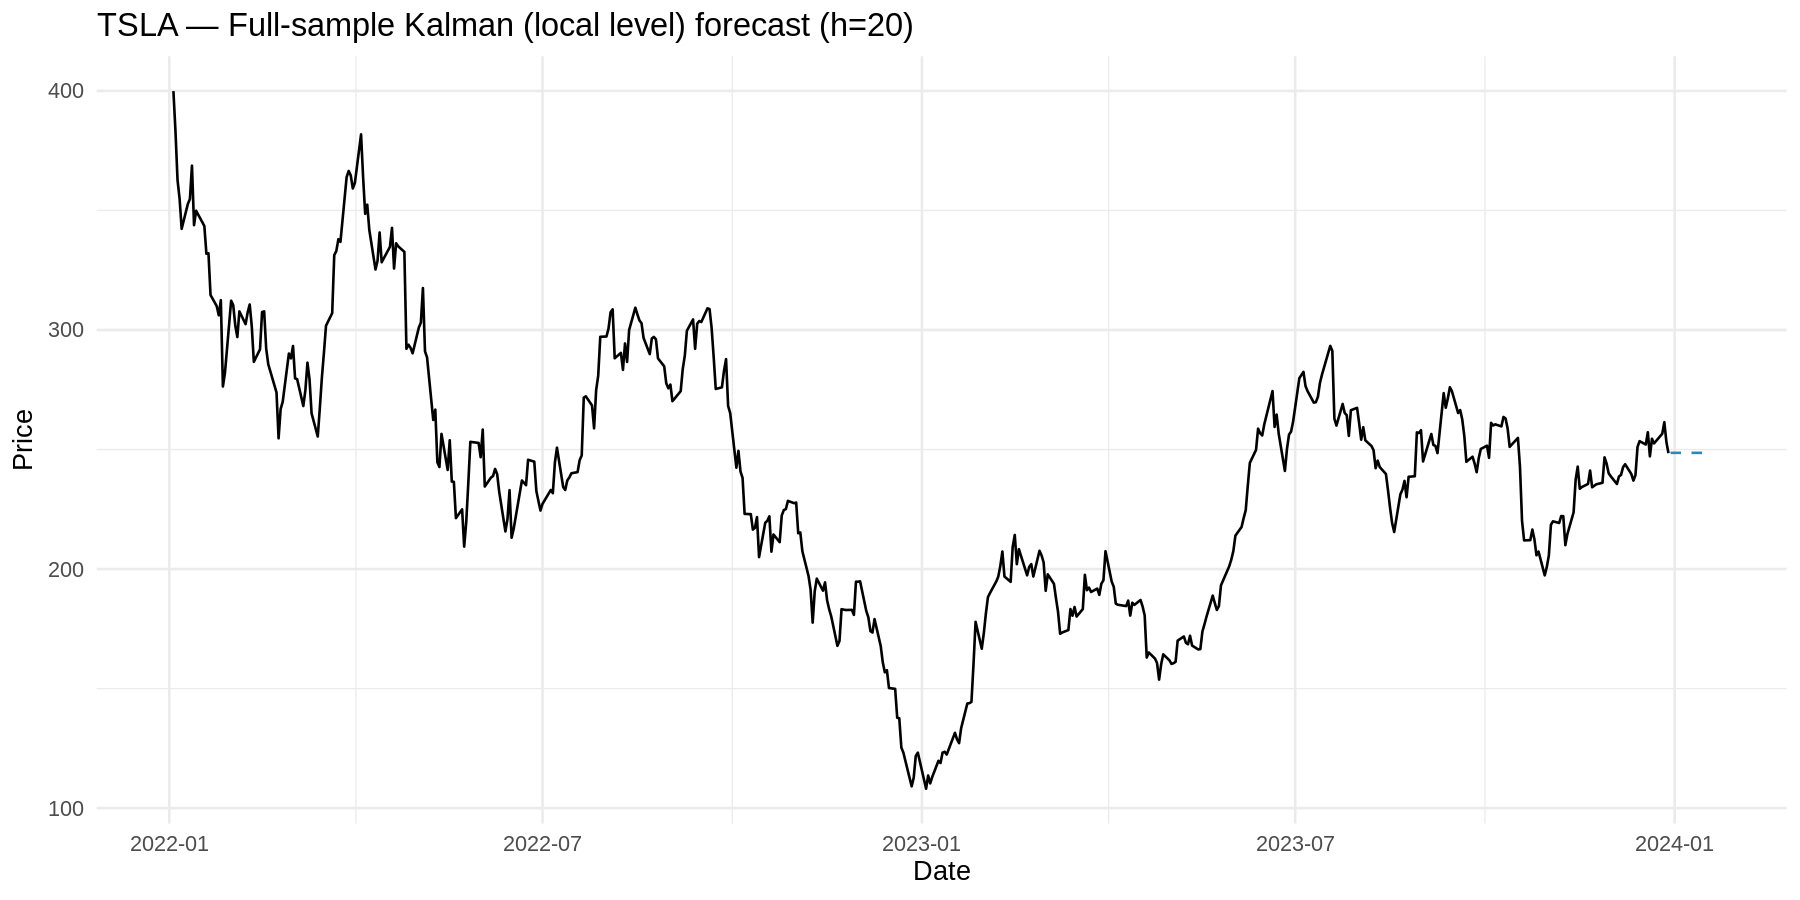

In [7]:
## ===========================
## 4) A) Full-sample (final fit) — 전체 표본 적합 → 미래 h 예측
## ===========================
h <- 20
fit_full <- fit_kfas_local_level(df$Close)
fcst_full <- predict_kfas(fit_full, h = h)

future_dates <- seq(from = df$Date[nrow(df)] + 1, by = "day", length.out = h)
g_full <- ggplot(df, aes(Date, Close)) +
  geom_line(color = "black") +
  geom_line(data = tibble(Date = future_dates, Close = fcst_full),
            aes(Date, Close), color = "#2E86C1", linetype = "dashed") +
  labs(title = sprintf("%s — Full-sample Kalman (local level) forecast (h=%d)", symbol, h),
       x = "Date", y = "Price")
print(g_full)


[Fixed-origin] RMSE=20.0356 | MAE=15.2924 | R2=-0.3222


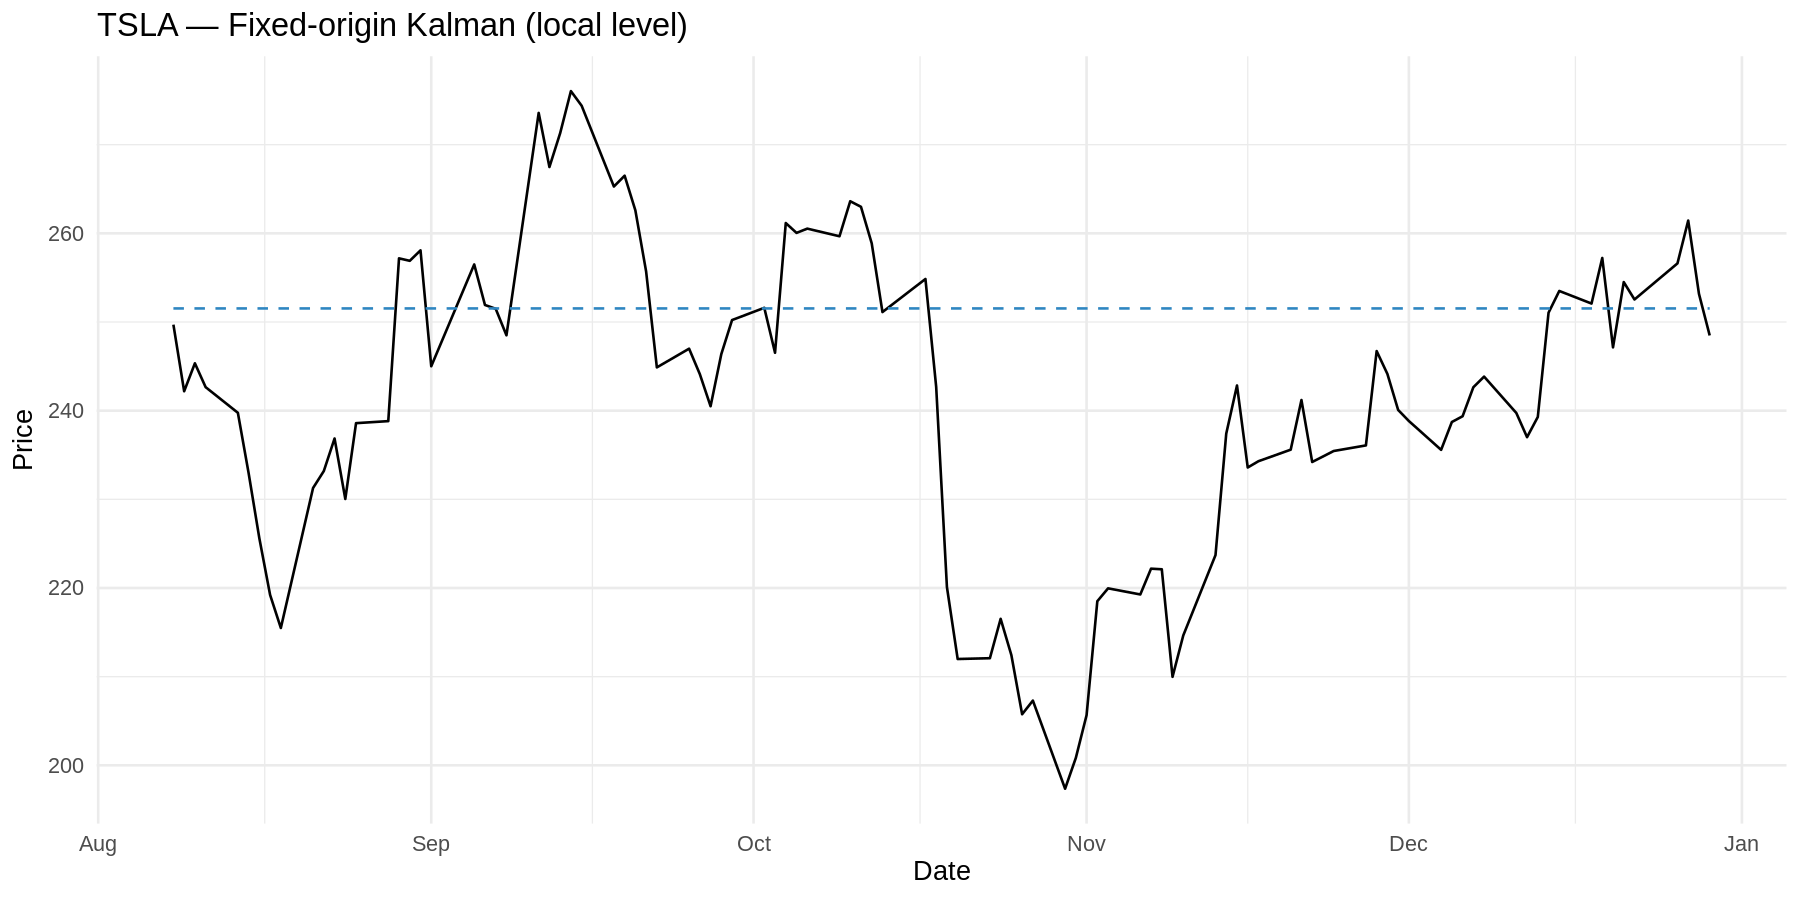

In [8]:
## ===========================
## 5) B) Fixed-origin (holdout) — 80% 학습 적합 → 테스트 전구간 예측
## ===========================
fit_fix <- fit_kfas_local_level(y_train)
pred_fix <- predict_kfas(fit_fix, h = length(y_test))

rmse_fix <- rmse(y_test, pred_fix)
mae_fix  <- mae (y_test, pred_fix)
r2_fix   <- r2  (y_test, pred_fix)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_fix, mae_fix, r2_fix))

df_fix <- tibble(Date = test$Date, Actual = y_test, Pred = pred_fix)
g_fix <- ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "#2E86C1", linetype = "dashed") +
  labs(title = sprintf("%s — Fixed-origin Kalman (local level)", symbol),
       x = "Date", y = "Price")
print(g_fix)


[Rolling window] RMSE=9.6087 | MAE=6.3831 | R2=0.6959


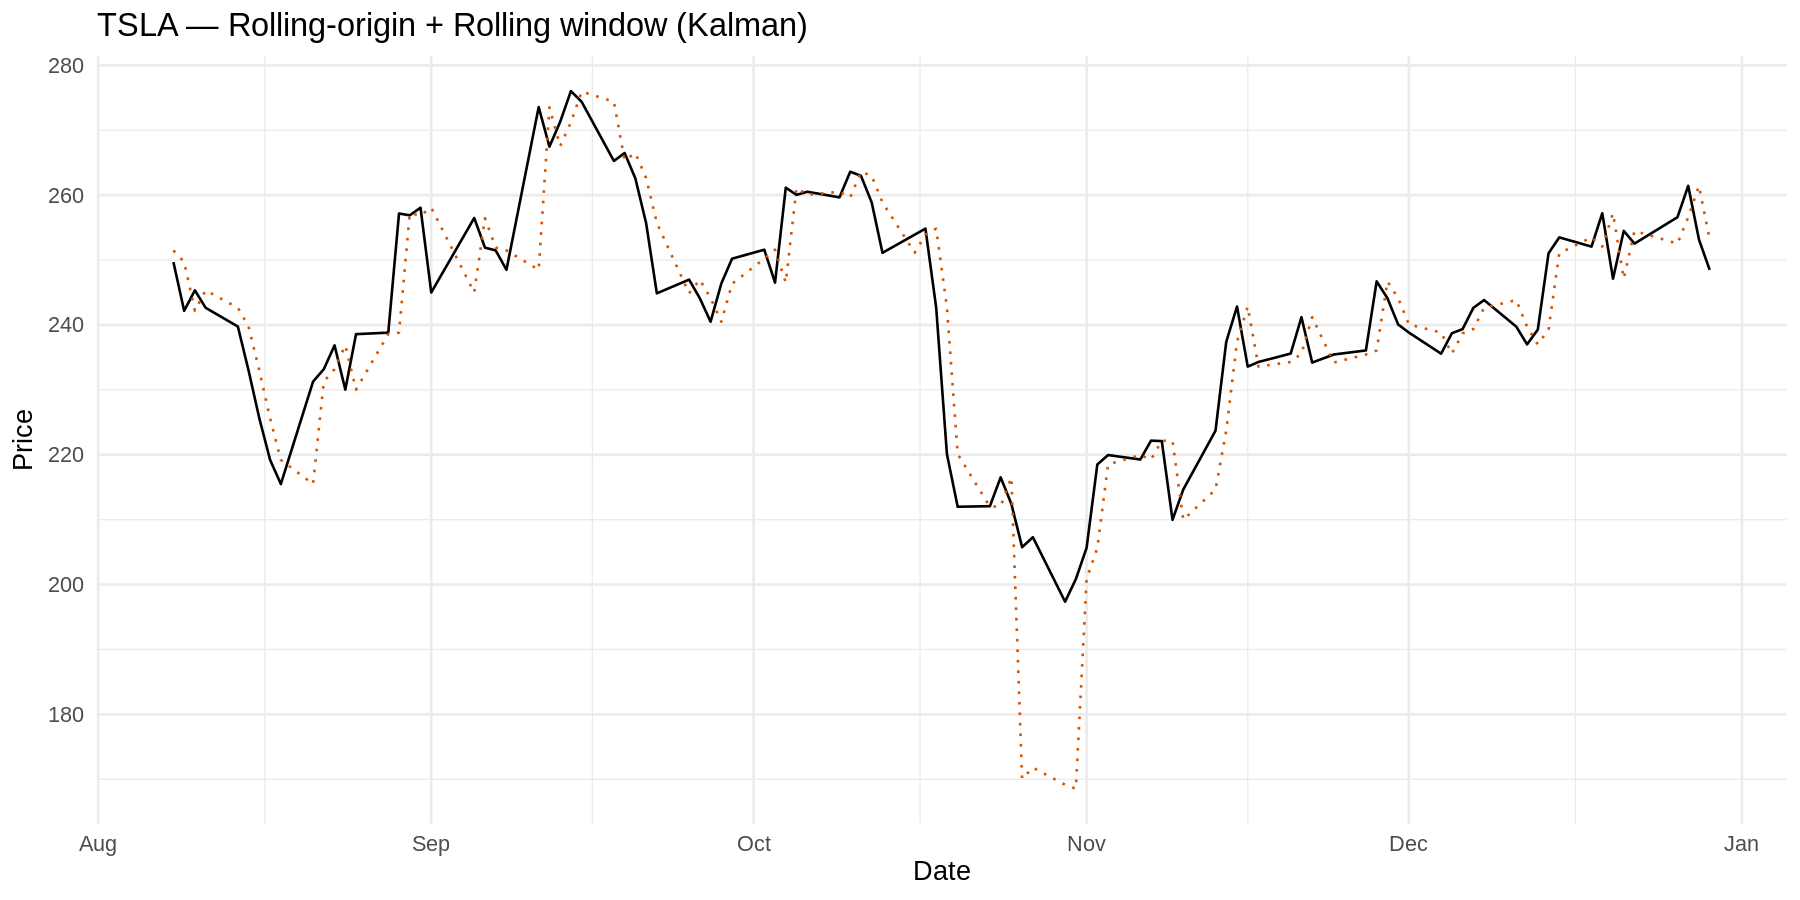

In [9]:
## ===========================
## 6) C) Rolling-origin + Rolling window (W개 최근값만)
## ===========================
W <- 120
pred_roll <- rep(NA_real_, length(y_test))
hist <- y_train
for (i in seq_along(y_test)) {
  y_win <- tail(hist, W)
  fit_i <- fit_kfas_local_level(y_win)
  pred_roll[i] <- predict_kfas(fit_i, h = 1)[1]
  hist <- c(hist, y_test[i])  # 워크-포워드
}

rmse_r <- rmse(y_test, pred_roll)
mae_r  <- mae (y_test, pred_roll)
r2_r   <- r2  (y_test, pred_roll)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_r, mae_r, r2_r))

df_roll <- tibble(Date = test$Date, Actual = y_test, Pred = pred_roll)
g_roll <- ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "#D35400", linetype = "dotted") +
  labs(title = sprintf("%s — Rolling-origin + Rolling window (Kalman)", symbol),
       x = "Date", y = "Price")
print(g_roll)


[Expanding window] RMSE=7.1185 | MAE=5.2858 | R2=0.8331


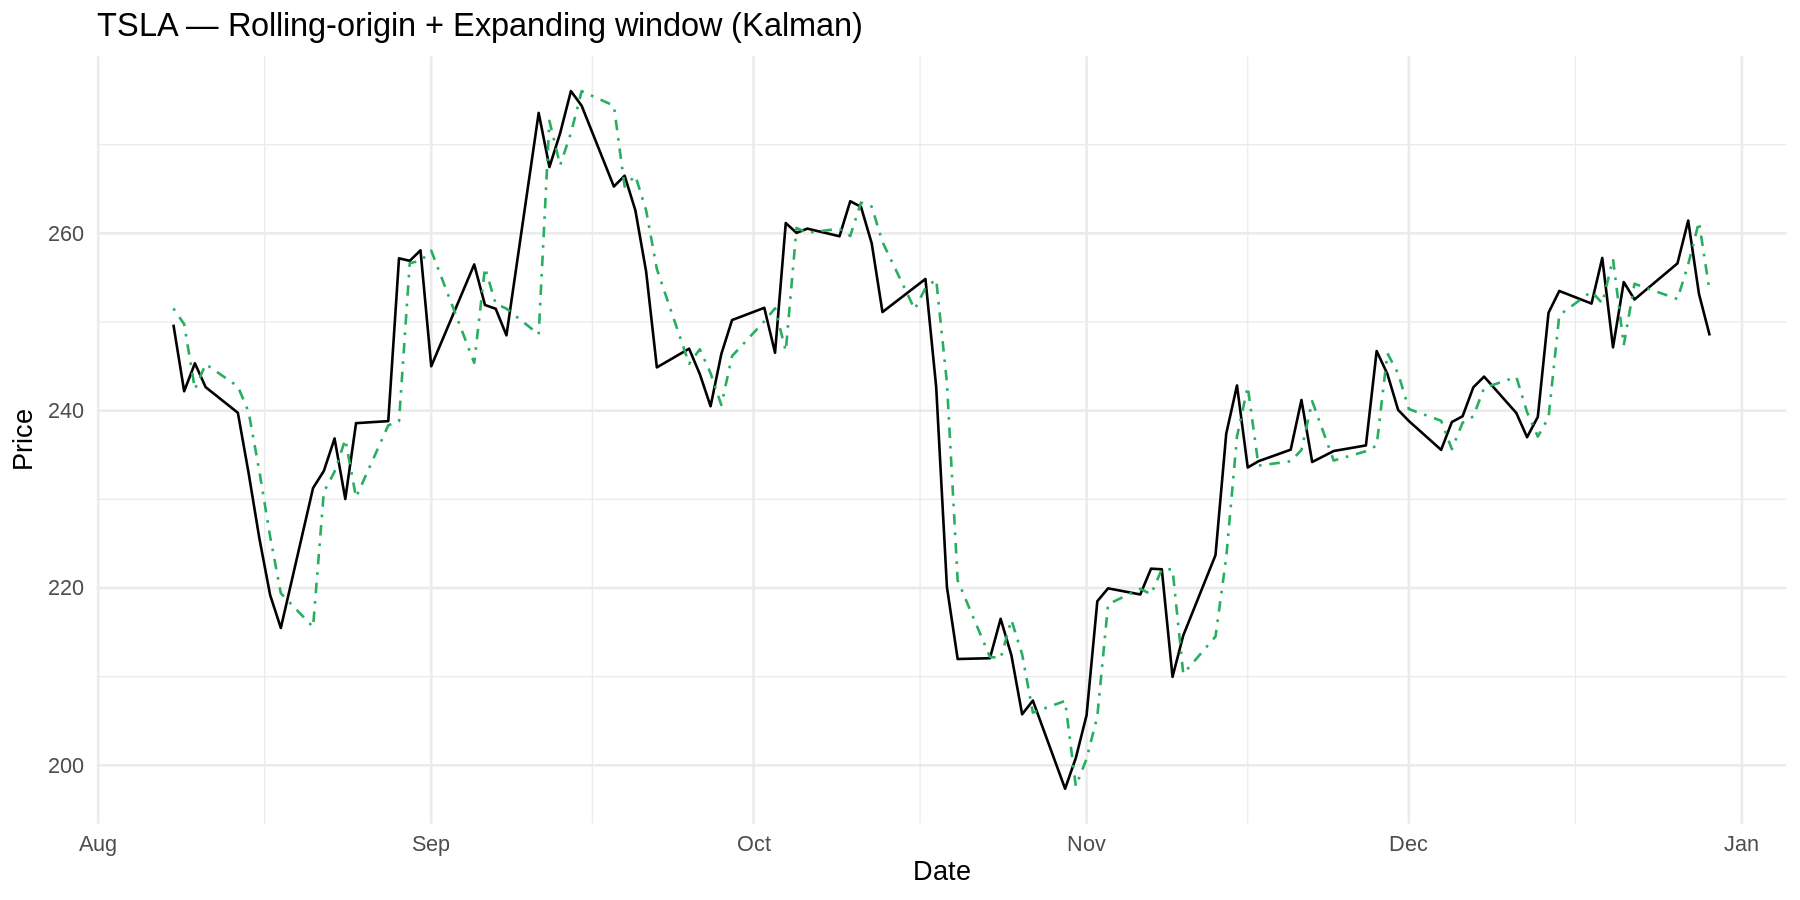

In [10]:
## ===========================
## 7) D) Rolling-origin + Expanding window (누적)
## ===========================
pred_exp <- rep(NA_real_, length(y_test))
hist <- y_train
for (i in seq_along(y_test)) {
  fit_i <- fit_kfas_local_level(hist)
  pred_exp[i] <- predict_kfas(fit_i, h = 1)[1]
  hist <- c(hist, y_test[i])
}

rmse_e <- rmse(y_test, pred_exp)
mae_e  <- mae (y_test, pred_exp)
r2_e   <- r2  (y_test, pred_exp)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_e, mae_e, r2_e))

df_exp <- tibble(Date = test$Date, Actual = y_test, Pred = pred_exp)
g_exp <- ggplot(df_exp, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "#27AE60", linetype = "dotdash") +
  labs(title = sprintf("%s — Rolling-origin + Expanding window (Kalman)", symbol),
       x = "Date", y = "Price")
print(g_exp)


# A tibble: 3 × 4
  Method            RMSE   MAE     R2
  <chr>            <dbl> <dbl>  <dbl>
1 Expanding window  7.12  5.29  0.833
2 Rolling window    9.61  6.38  0.696
3 Fixed-origin     20.0  15.3  -0.322


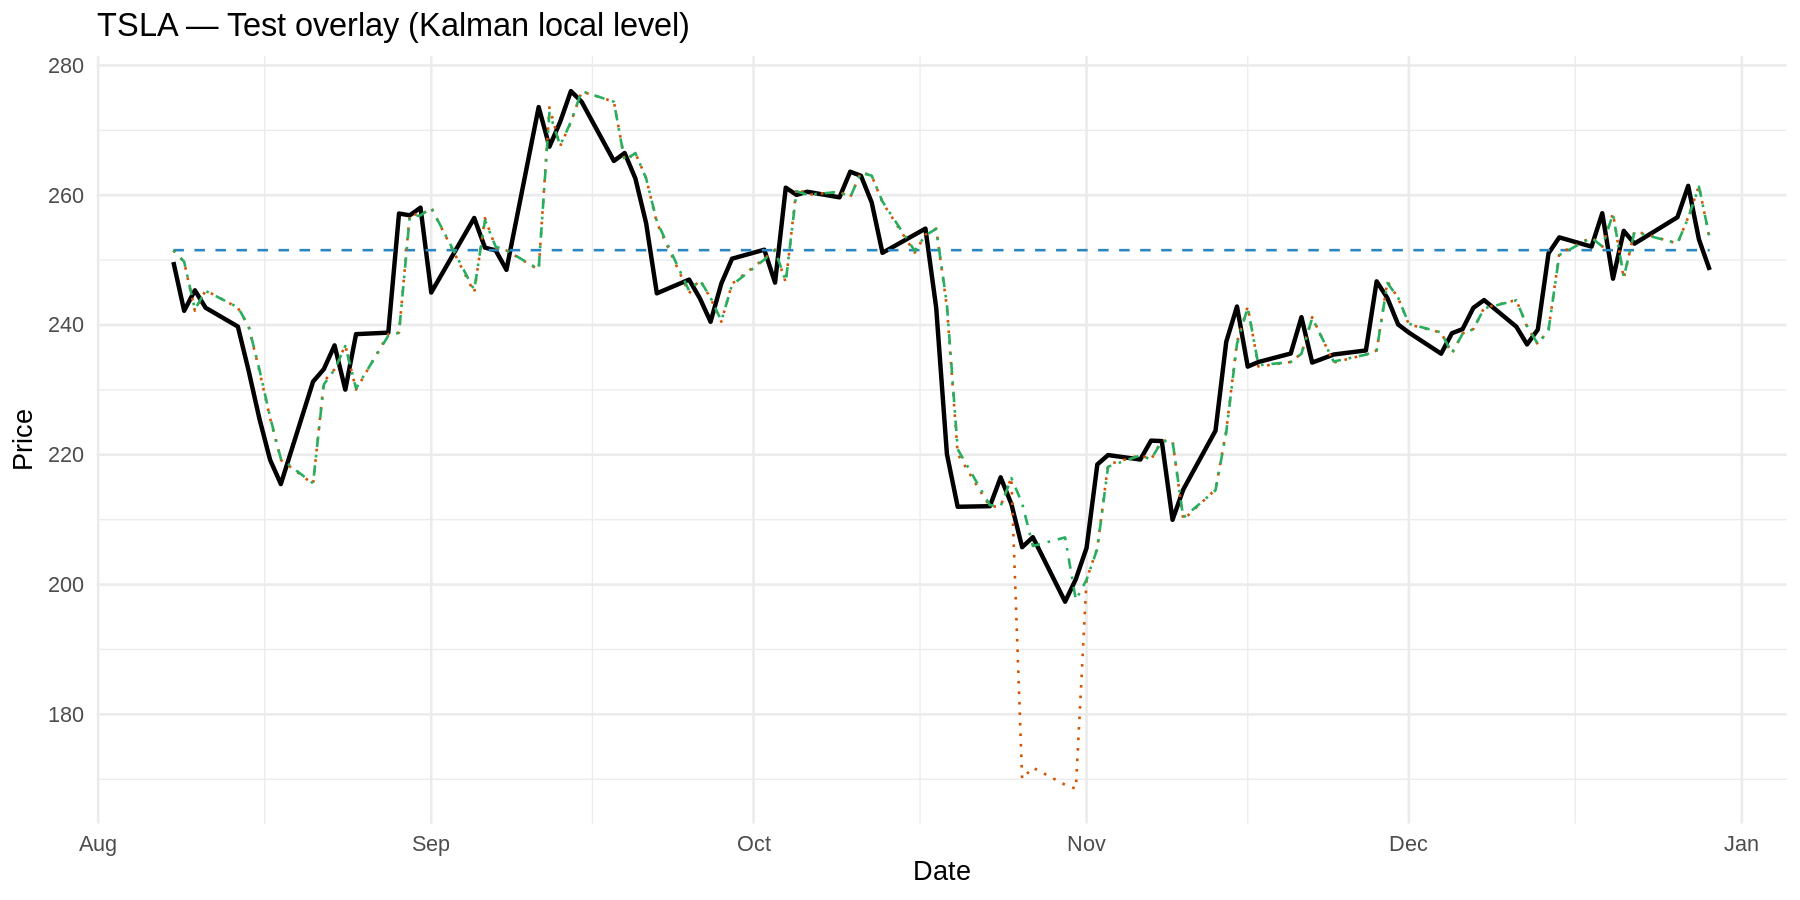

In [11]:
## ===========================
## 8) 요약 표 & 오버레이
## ===========================
summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)
print(summary_tbl)

ggplot() +
  geom_line(data = tibble(Date = test$Date, Price = y_test), aes(Date, Price), color = "black", linewidth = 1) +
  geom_line(data = tibble(Date = test$Date, Price = pred_fix),  aes(Date, Price), linetype = "dashed", color = "#2E86C1") +
  geom_line(data = tibble(Date = test$Date, Price = pred_roll), aes(Date, Price), linetype = "dotted", color = "#D35400") +
  geom_line(data = tibble(Date = test$Date, Price = pred_exp),  aes(Date, Price), linetype = "dotdash", color = "#27AE60") +
  labs(title = sprintf("%s — Test overlay (Kalman local level)", symbol), x = "Date", y = "Price")


칼만필터 2

[1] "TSLA"

TSLA: 501 obs | 2022-01-03 ~ 2023-12-29
train=400, test=101
[Fixed-origin] RMSE=92.2933 | MAE=81.3897 | R2=-27.0561


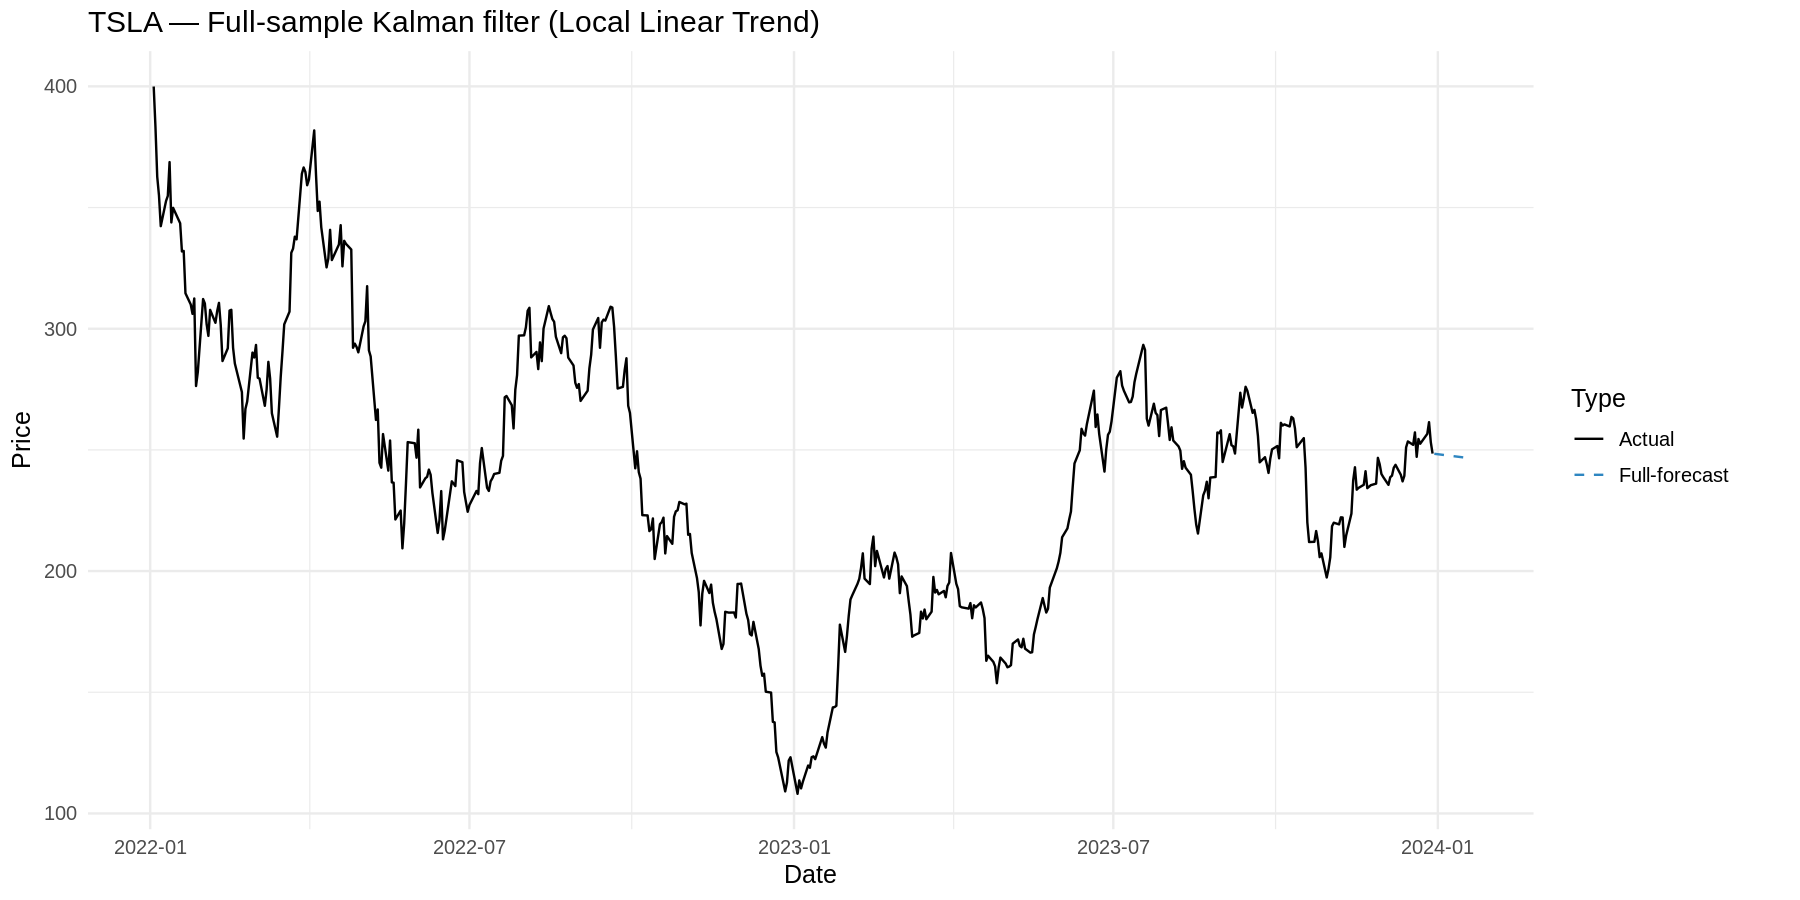

[Rolling window] RMSE=7.2594 | MAE=5.4112 | R2=0.8264


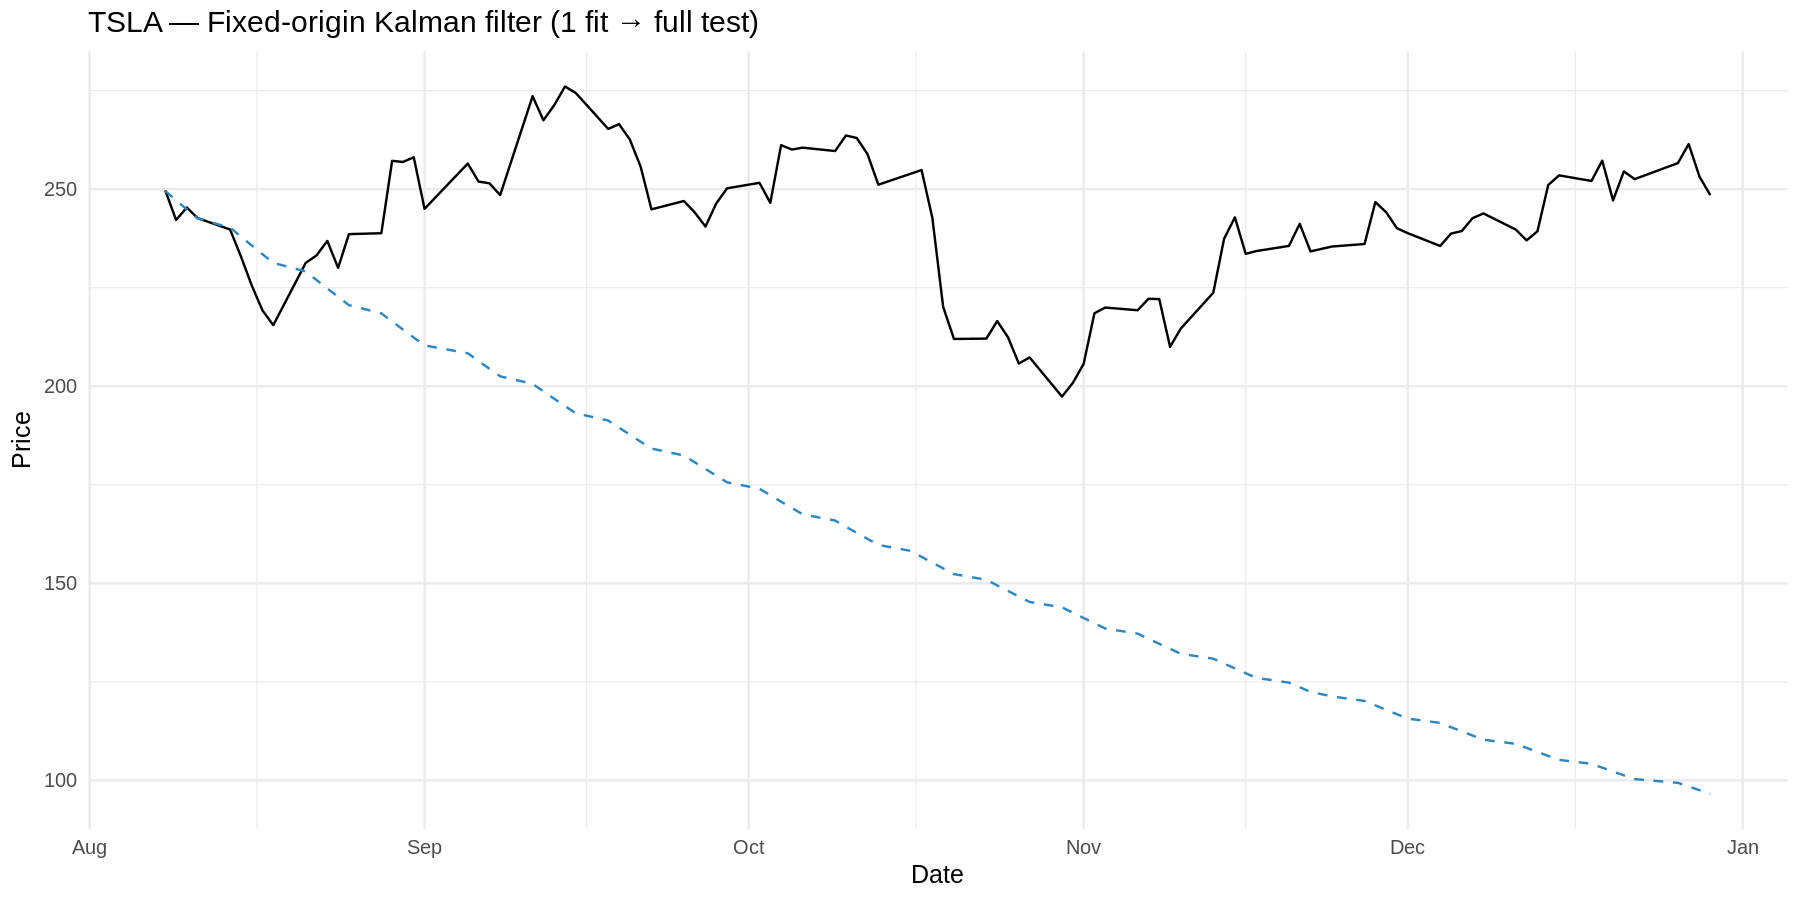

[Expanding window] RMSE=7.4155 | MAE=5.4332 | R2=0.8189
# A tibble: 3 × 4
  Method            RMSE   MAE      R2
  <chr>            <dbl> <dbl>   <dbl>
1 Rolling window    7.26  5.41   0.826
2 Expanding window  7.42  5.43   0.819
3 Fixed-origin     92.3  81.4  -27.1  


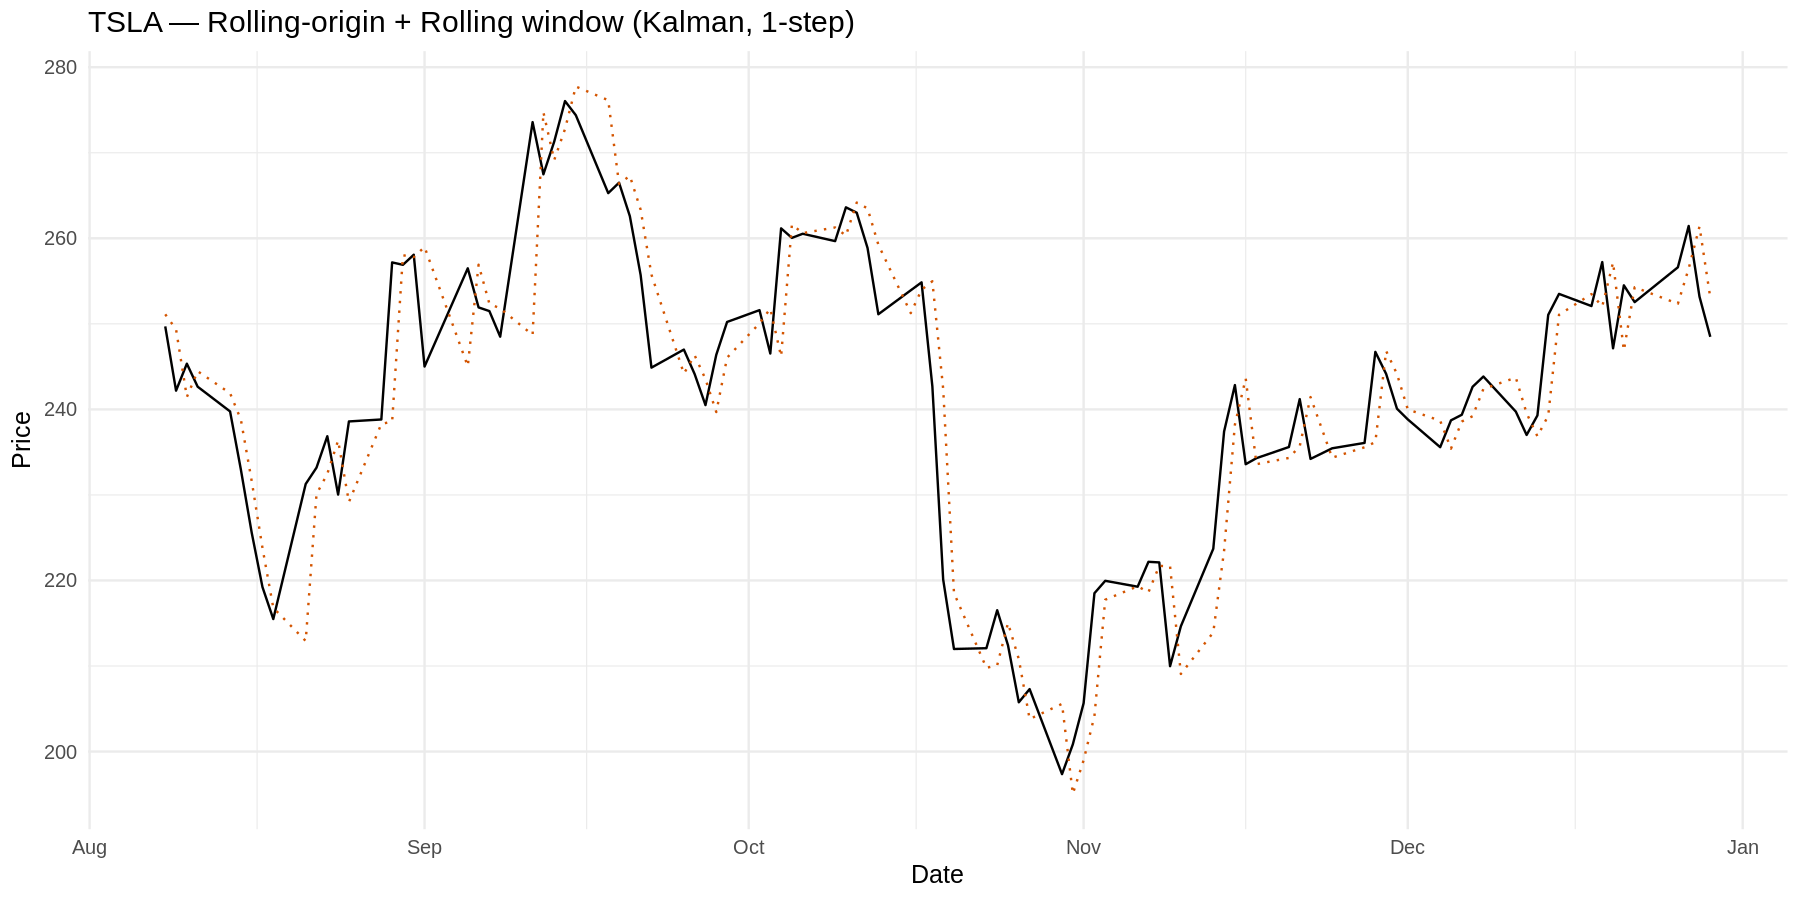

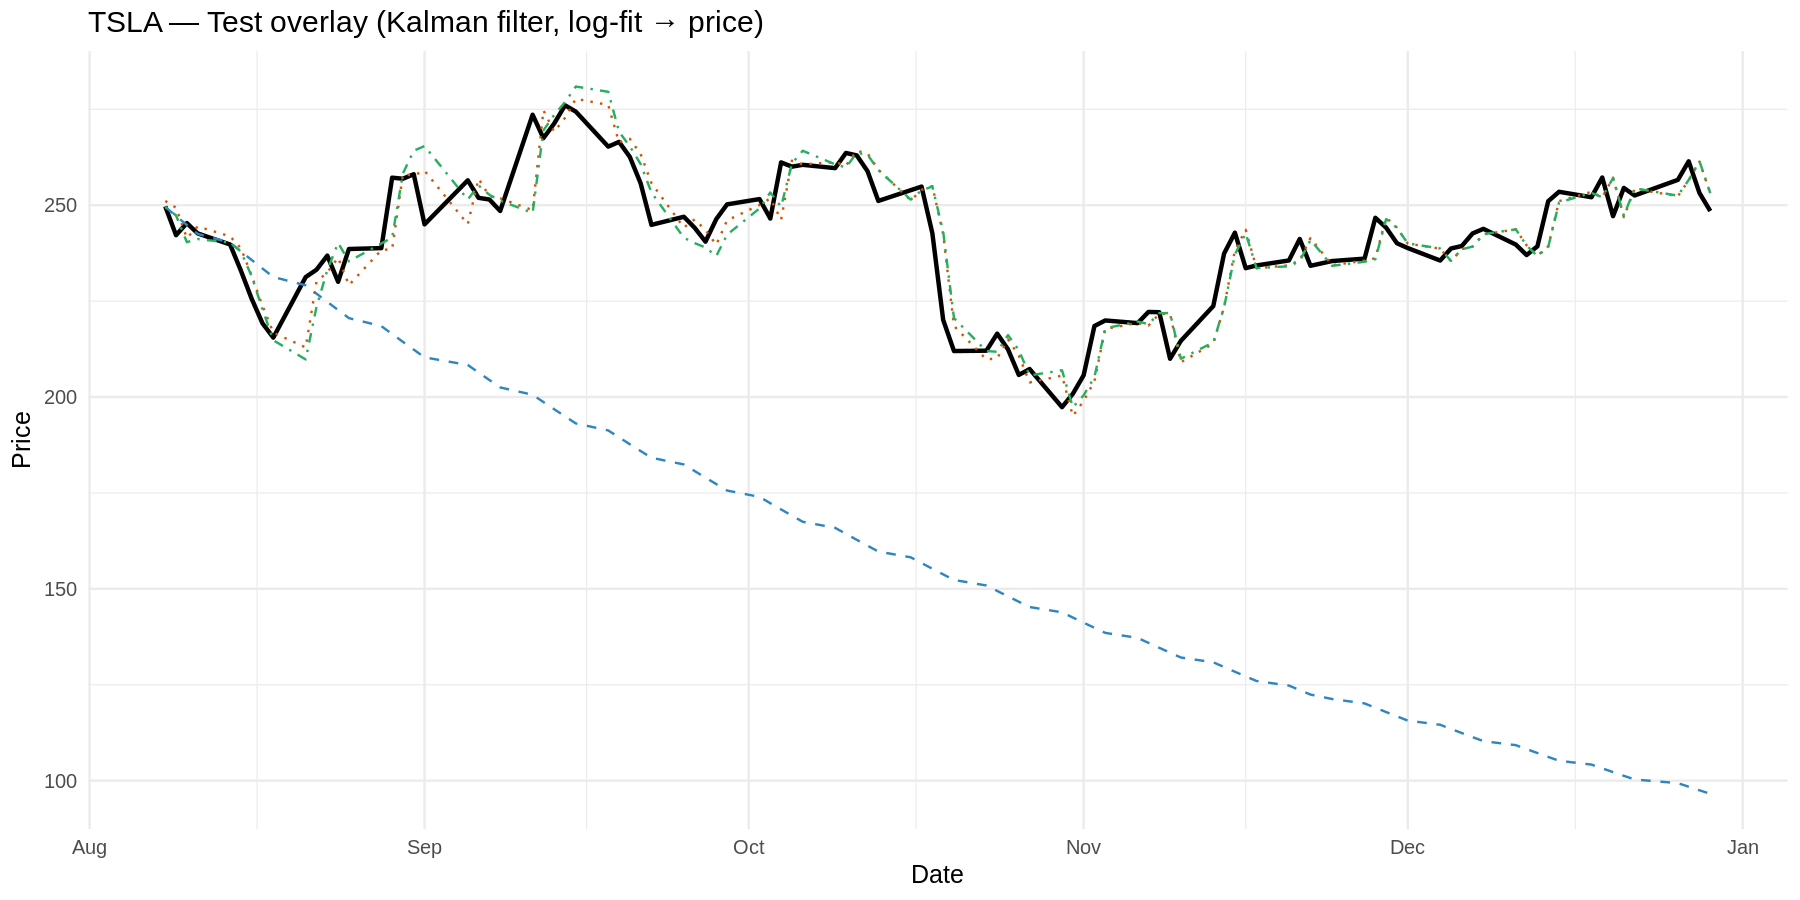

In [12]:
# ===========================
# Colab 준비 & 패키지
# ===========================
pkgs <- c("quantmod", "KFAS", "ggplot2", "dplyr", "tibble", "purrr")
to_install <- pkgs[!(pkgs %in% rownames(installed.packages()))]
if (length(to_install)) install.packages(to_install, repos = "https://cloud.r-project.org")

suppressPackageStartupMessages({
  library(quantmod); library(KFAS); library(ggplot2)
  library(dplyr);    library(tibble); library(purrr)
})

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)
theme_set(theme_minimal(base_size = 12))

# ===========================
# 1) 데이터: TSLA 종가 → 로그가격
# ===========================
symbol <- "TSLA"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

suppressWarnings(suppressMessages(
  getSymbols(Symbols = symbol, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
))
px_xts <- Ad(get(symbol))      # Adjusted Close
px     <- na.omit(px_xts)
yP     <- as.numeric(px)       # 가격
dates  <- index(px)

yL <- log(yP)                  # 로그가격(칼만 필터 모형 대상)

cat(sprintf("%s: %d obs | %s ~ %s\n", symbol, length(yP), as.Date(dates[1]), as.Date(dates[length(dates)])))

# ===========================
# 2) 학습/테스트 분할 (80/20)
# ===========================
n <- length(yL)
split <- floor(n * 0.8)
yL_train <- yL[1:split]
yL_test  <- yL[(split + 1):n]
dates_train <- dates[1:split]
dates_test  <- dates[(split + 1):n]
yP_train <- yP[1:split]
yP_test  <- yP[(split + 1):n]

cat(sprintf("train=%d, test=%d\n", length(yL_train), length(yL_test)))

# ===========================
# 3) 유틸 함수
# ===========================
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res / ss_tot
}

# Local Linear Trend (level+trend) 상태공간 모형
build_trend <- function(y_vec) {
  # H, Q를 추정(NA)하게 둠
  SSModel(y_vec ~ SSMtrend(degree = 2, Q = list(NA, NA)), H = NA)
}

fit_kfas <- function(y_vec) {
  mod <- build_trend(y_vec)
  # 초기값: 분산 대략치(로그 변환으로 양수 제약)
  inits <- log(c(
    var(y_vec, na.rm = TRUE) %||% 1e-4,
    var(diff(y_vec), na.rm = TRUE) %||% 1e-6,
    var(diff(diff(y_vec)), na.rm = TRUE) %||% 1e-8
  ))
  inits[!is.finite(inits)] <- -6  # 너무 작거나 NA면 안전값
  fit <- tryCatch(fitSSM(mod, inits = inits, method = "BFGS"),
                  error = function(e) NULL)
  fit
}

pred_kfas <- function(fit, h) {
  if (is.null(fit)) return(rep(NA_real_, h))
  # 예측은 y의 스케일(여기서는 로그가격)로 반환
  as.numeric(predict(fit$model, n.ahead = h, interval = "none"))
}

one_step_kfas <- function(y_hist) {
  fit <- fit_kfas(y_hist)
  if (is.null(fit)) return(tail(y_hist, 1))
  as.numeric(predict(fit$model, n.ahead = 1))
}

`%||%` <- function(a, b) if (!is.null(a) && is.finite(a)) a else b

# ===========================
# 4) A) Full-sample (final fit)
#    전체로 적합 → 미래 h 스텝 예측 (평가용 X)
# ===========================
h <- 20
fit_full <- fit_kfas(yL)
log_fcst <- pred_kfas(fit_full, h)  # 로그가격 예측
price_fcst <- exp(log_fcst)

future_dates <- seq(from = dates[length(dates)] + 1, by = "day", length.out = h)
df_full <- tibble(Date = c(dates, future_dates),
                  Price = c(yP, price_fcst),
                  Type  = c(rep("Actual", length(yP)), rep("Full-forecast", h)))

ggplot(df_full, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black", "Full-forecast" = "#2E86C1")) +
  scale_linetype_manual(values = c("Actual" = "solid", "Full-forecast" = "dashed")) +
  labs(title = sprintf("%s — Full-sample Kalman filter (Local Linear Trend)", symbol),
       x = "Date", y = "Price")

# ===========================
# 5) B) Fixed-origin (holdout)
#    학습(80%)에 대해 한 번 적합 → 테스트 전체 예측
# ===========================
fit_fix <- fit_kfas(yL_train)
log_pred_fix <- pred_kfas(fit_fix, length(yL_test))
pred_fix <- exp(log_pred_fix)  # 가격 스케일

rmse_fix <- rmse(yP_test, pred_fix)
mae_fix  <- mae (yP_test, pred_fix)
r2_fix   <- r2  (yP_test, pred_fix)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_fix, mae_fix, r2_fix))

df_fix <- tibble(Date = dates_test,
                 Actual = yP_test,
                 Pred   = pred_fix)

ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "#2E86C1", linetype = "dashed") +
  labs(title = sprintf("%s — Fixed-origin Kalman filter (1 fit → full test)", symbol),
       x = "Date", y = "Price")

# ===========================
# 6) C) Rolling-origin + Rolling window
#    고정 창 W로 매 스텝 재적합 → 1-step 예측
# ===========================
W <- 120
pred_roll_log <- rep(NA_real_, length(yL_test))
hist <- yL_train

for (i in seq_along(yL_test)) {
  y_win <- if (length(hist) > W) tail(hist, W) else hist
  pred_roll_log[i] <- one_step_kfas(y_win)
  # 워크-포워드(실제값 주입)
  hist <- c(hist, yL_test[i])
}
pred_roll <- exp(pred_roll_log)

rmse_r <- rmse(yP_test, pred_roll)
mae_r  <- mae (yP_test, pred_roll)
r2_r   <- r2  (yP_test, pred_roll)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_r, mae_r, r2_r))

df_roll <- tibble(Date = dates_test, Actual = yP_test, Pred = pred_roll)
ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "#D35400", linetype = "dotted") +
  labs(title = sprintf("%s — Rolling-origin + Rolling window (Kalman, 1-step)", symbol),
       x = "Date", y = "Price")

# ===========================
# 7) D) Rolling-origin + Expanding window
#    누적 창으로 매 스텝 재적합 → 1-step 예측
# ===========================
pred_exp_log <- rep(NA_real_, length(yL_test))
hist <- yL_train

for (i in seq_along(yL_test)) {
  pred_exp_log[i] <- one_step_kfas(hist)
  hist <- c(hist, yL_test[i])
}
pred_exp <- exp(pred_exp_log)

rmse_e <- rmse(yP_test, pred_exp)
mae_e  <- mae (yP_test, pred_exp)
r2_e   <- r2  (yP_test, pred_exp)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_e, mae_e, r2_e))

# ===========================
# 8) 요약 & 오버레이
# ===========================
summary_tbl <- tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)

print(summary_tbl)

ggplot() +
  geom_line(data = tibble(Date = dates_test, Price = yP_test),
            aes(Date, Price), color = "black", linewidth = 1) +
  geom_line(data = tibble(Date = dates_test, Price = pred_fix),
            aes(Date, Price), linetype = "dashed", color = "#2E86C1") +
  geom_line(data = tibble(Date = dates_test, Price = pred_roll),
            aes(Date, Price), linetype = "dotted", color = "#D35400") +
  geom_line(data = tibble(Date = dates_test, Price = pred_exp),
            aes(Date, Price), linetype = "dotdash", color = "#27AE60") +
  labs(title = sprintf("%s — Test overlay (Kalman filter, log-fit → price)", symbol),
       x = "Date", y = "Price")
